# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## 1) Business Understanding

The objective here is to find patterns and show when and where to give specific offer to a specific customer.

## 2) Data Understanding

In [1]:
import pandas as pd
import numpy as np
import math
import json


import matplotlib.pyplot as plt
import seaborn as sns


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [7]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [8]:
portfolio.shape

(10, 6)

In [9]:
profile.shape

(17000, 5)

In [10]:
transcript.shape

(306534, 4)

## 3) Data Preparation/Wrangling 

In [11]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


each channel can be in a seprate column instead of putting them all together 

In [12]:
#extract all channels names 

channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))
channels_set    

{'email', 'mobile', 'social', 'web'}

In [13]:
# split the channel into different attribute
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
portfolio.head()    

,reward,channels,difficulty,duration,offer_type,id,mobile,social,web,email
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,1


In [14]:
# Now drop the 'channels' column 
portfolio = portfolio.drop('channels', axis=1)
portfolio

,reward,difficulty,duration,offer_type,id,mobile,social,web,email
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,0,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,0,1,1


looks better! whats better is that we don't have any NaN values!!!.

on to the next dataframe

In [15]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


it looks like that we have some NaN's and some None in both 'gender' and 'income' columns.

In [17]:
#num of nan and none
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

for the income will we replace nan with the avg, and for the gender replace none with N/A

In [18]:
profile['gender'].fillna('NA', inplace=True)
profile['income'].fillna((profile['income'].mean()), inplace=True)

In [19]:
profile.isna().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

Great!

In [20]:
profile

,gender,age,id,became_member_on,income
0,NA,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000
2,NA,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000
4,NA,118,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.000000
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.000000
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.000000
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.000000


While working through the data I notices that there is age number 118 which seems impossible to happen and to make sure I also noticed that for all profiles that have age equal to 118, they also don't have gender listed so it might be written wrong or it is the default value. For those values I will keep 118 as it is.

Now let's see the transcript dataframe

In [21]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [22]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

No NaN again thats nice :).

However, 'value' seems to hold a dictionary

In [23]:
# find different keys in value column
keys = []
for idx, row in transcript.iterrows():
    for k in row['value']:
        if k in keys:
            continue
        else:
            keys.append(k)

keys 

['offer id', 'amount', 'offer_id', 'reward']

In [24]:
# Iterate over transcript table, check value column and update it, put each key in seperated column.
transcript['offer_id'] = ''
transcript['amount'] = 0
transcript['reward'] = 0

for idx, row in transcript.iterrows():
    for k in row['value']:
        if k == 'offer_id' or k == 'offer id':
            transcript.at[idx, 'offer_id']= row['value'][k]
        if k == 'amount':
            transcript.at[idx, 'amount']= row['value'][k]
        if k == 'reward':
            transcript.at[idx, 'reward']= row['value'][k]

In [25]:
transcript

,person,event,value,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,,9,0
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,,3,0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,,3,0


In [26]:
transcript = transcript.drop('value', axis=1)
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


Looks Good!

Everything looks setup for Analysis and Modeling

## 4) Analyzing/Modeling Data

 ### 4.1) Analyzing Data

#### 4.1.1)  Univariate Exploration:

1. What is the average income for Starbucks customers?
2. What is the average age for Starbucks customers?
3. What is the most common promotion?
4. What are the most common values for each column in each dataframe?
5. Who are the most loyal customer (most transcripts)?

Let's start with the first question:

1. What is the average income for Starbucks customers?

In [27]:
profile['income'].mean()

65404.99156829799

2. What is the average age for Starbucks customers?

In [28]:
profile['age'].mean()

62.53141176470588

3. What is the most common promotion?

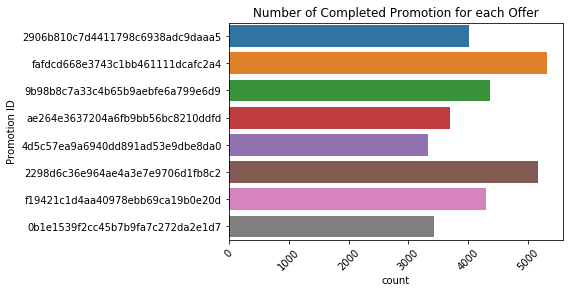

In [29]:
# We we check the completed orders only

completed_off_count = transcript[transcript['event'] == 'offer completed']

sns.countplot(y=completed_off_count['offer_id'])
plt.title('Number of Completed Promotion for each Offer')
plt.ylabel('Promotion ID')
plt.xticks(rotation = 45)
plt.show();

In [30]:
def get_offer_type(offer_id):
    '''
    input: offer_id: id of offer
    
    output: offer type
    
    '''
    
    try:
        offer_type = portfolio[portfolio['id'] == offer_id]['offer_type'].values[0]
        return offer_type
    except:
        offer_type = 'NA'
        return offer_type

transcript['offer_type'] = transcript.apply(lambda x: get_offer_type(x['offer_id']), axis=1)

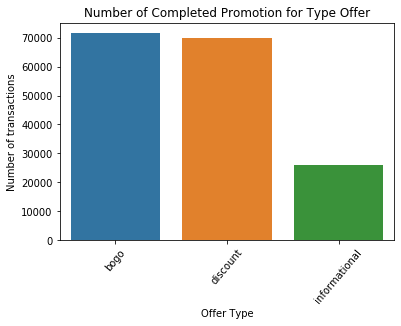

In [31]:
sns.countplot(transcript[transcript['offer_type'] != 'NA']['offer_type'])
plt.title('Number of Completed Promotion for Type Offer')
plt.ylabel('Number of transactions')
plt.xlabel('Offer Type')
plt.xticks(rotation = 50)
plt.show();

*Bogo* and *Discount* seem the most and they are close to each other with *bogo* been slightly higher

4. What are the most common values for each column in each dataframe?

In [32]:

profile['age_groups'] = pd.cut(profile.age, bins=[0, 12, 18, 21, 64, 200], 
                               labels=['child', 'teen', 'young adult', 'adult', 'elderly'])

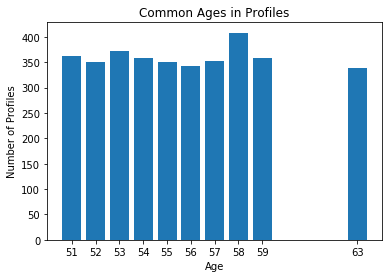

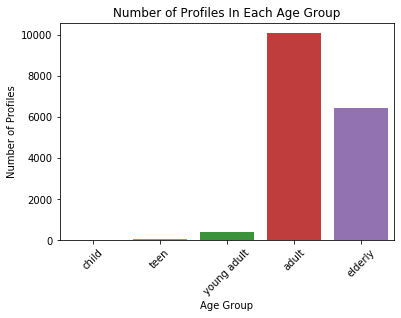

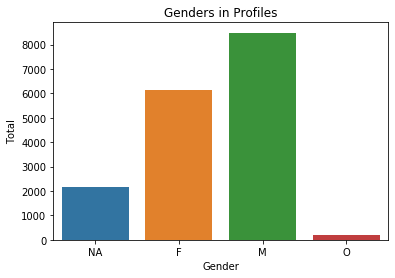

In [33]:
# 118 is an outlier, so it is not included
top10_ages = profile['age'].value_counts()[1:].head(10).reset_index()
plt.bar(top10_ages['index'], top10_ages['age'])
plt.title('Common Ages in Profiles')
plt.ylabel('Number of Profiles')
plt.xlabel('Age')
plt.xticks(top10_ages['index'], rotation = 0)
plt.show();

sns.countplot(x='age_groups', data=profile)
plt.title('Number of Profiles In Each Age Group')
plt.ylabel('Number of Profiles')
plt.xlabel('Age Group')
plt.xticks(rotation = 45)
plt.show();

sns.countplot(profile['gender'])
plt.title('Genders in Profiles')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

Most are Adults and Males, interesting...

5. Who are the most loyal customer, in other words most transcripts?

In [34]:
loyal_customer_count = transcript[(transcript['event'] == 'offer completed') | (transcript['event'] == 'transaction')].groupby(['person', 'event'])['amount'].sum().reset_index()
loyal_customer_count = loyal_customer_count.sort_values('amount', ascending=False).head(10)
count = 1

for idx, row in loyal_customer_count.iterrows():
    print(f'.------------------- [ #{count} ] ------------------.')
    print(f'| Profile ID: {row["person"]} |')
    print(f'| Number of Completed Offers:       {completed_off_count[(completed_off_count["person"] == row["person"]) & (completed_off_count["event"] == "offer completed")].shape[0]}          |')
    print(f'| Amount:                         ${row["amount"]}        |')
    print(f"'----------------------------------------------'")
    count += 1

.------------------- [ #1 ] ------------------.
| Profile ID: 3c8d541112a74af99e88abbd0692f00e |
| Number of Completed Offers:       5          |
| Amount:                         $1606        |
'----------------------------------------------'
.------------------- [ #2 ] ------------------.
| Profile ID: f1d65ae63f174b8f80fa063adcaa63b7 |
| Number of Completed Offers:       6          |
| Amount:                         $1360        |
'----------------------------------------------'
.------------------- [ #3 ] ------------------.
| Profile ID: ae6f43089b674728a50b8727252d3305 |
| Number of Completed Offers:       3          |
| Amount:                         $1320        |
'----------------------------------------------'
.------------------- [ #4 ] ------------------.
| Profile ID: 626df8678e2a4953b9098246418c9cfa |
| Number of Completed Offers:       4          |
| Amount:                         $1314        |
'----------------------------------------------'
.------------------- [ #

now that we have completed the Univariate Exploration, let's start looking at Multvariate Exploration.

#### 4.1.2) Multvariate Exploration:

1. What is the most common promotion for children, teens, young adult, adult and elderly customors?
2. From profiles, which get more income, males or females?
3. Which type of promotions each gender likes?

Let's go!

1. What is the most common promotion for children, teens, young adult, adult and elderly customors?

In [35]:
#get age group from profile dataframe
def get_customer_age_group(profile_id):
    age_group = profile[profile['id'] == profile_id]['age_groups'].values[0]
    return age_group

transcript['age_group'] = transcript.apply(lambda x: get_customer_age_group(x['person']), axis=1)

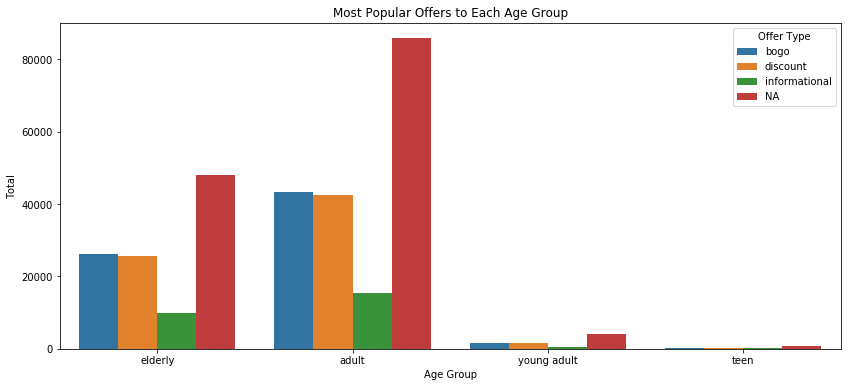

In [36]:
plt.figure(figsize=(14, 6))
sns.countplot(x="age_group", hue="offer_type", data=transcript)
plt.title('Most Popular Offers to Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
plt.xticks(rotation = 0)
plt.legend(title='Offer Type')
plt.show();

2. From profiles dataframe, which get more income: Males, Females, or Other?

Note: ignoring N/A because they didn't tell their gender

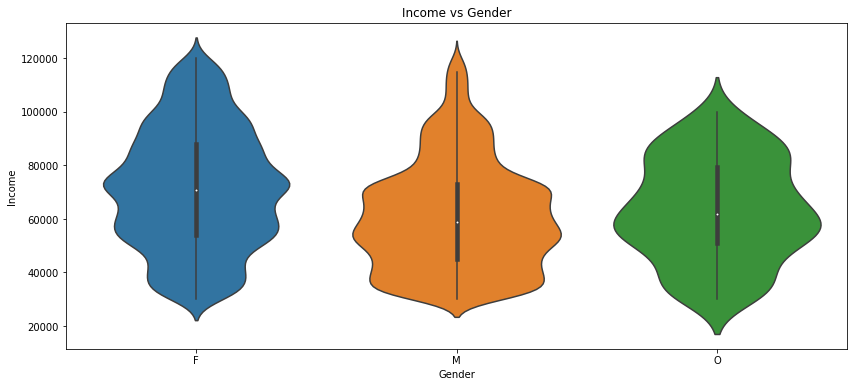

In [37]:
plt.figure(figsize=(14, 6))
sns.violinplot(x=profile[profile['gender'] != 'NA']['gender'], y=profile['income'])
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

Note: the white dot in each graph represents the median

3. Which type of promotions each gender likes?

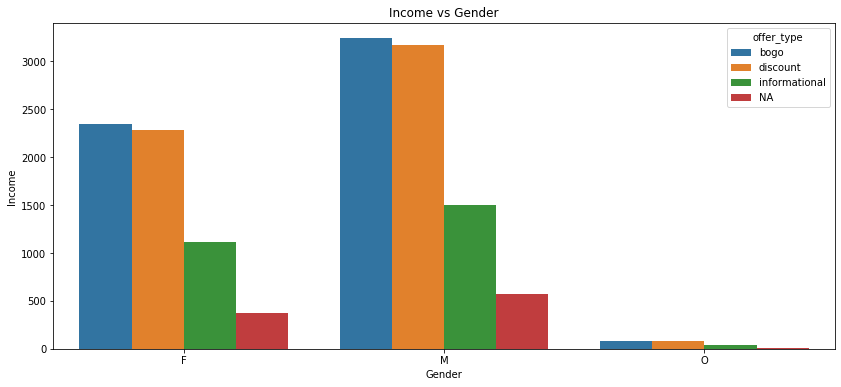

In [38]:
plt.figure(figsize=(14, 6))
sns.countplot(x=profile[profile['gender'] != 'NA']['gender'], hue = 'offer_type', data=transcript)
plt.title('Income vs Gender')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

We can see that Male and Female prefer *Bogo* 😄. In Others(O), *Bogo* and *discount* are the same.

Now it's time for the Modeling part.

### 4.2) Modeling Data

In this part, we are going to build a machine learning model that predicts whether or not someone will respond to an offer.

In [39]:
#Because my model will guess the offer_type, I will only get those transcripts with offer id's.
transcript = transcript[transcript['offer_id'] != 'NA']

We need to add gender and income to transcrip so we can use all we need in one file here, I will make function to do so (It takes time to run).

In [40]:
def get_customer_gender(profile_id):
    gender = profile[profile['id'] == profile_id]['gender'].values[0]
    return gender

transcript['gender'] = transcript.apply(lambda x: get_customer_gender(x['person']), axis=1)

In [41]:
def get_customer_income(profile_id):
    income = profile[profile['id'] == profile_id]['income'].values[0]
    return income

transcript['income'] = transcript.apply(lambda x: get_customer_income(x['person']), axis=1)

In [42]:
transcript.head()

,person,event,time,offer_id,amount,reward,offer_type,age_group,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,bogo,elderly,F,100000.000000
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,discount,elderly,NA,65404.991568
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0,discount,elderly,M,70000.000000
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0,discount,elderly,NA,65404.991568
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0,bogo,elderly,NA,65404.991568


Now we should split our dataframe to features and target

In [43]:
# Our Features:
# reference: https://www.datacamp.com/community/tutorials/categorical-data
labels_event = transcript['event'].astype('category').cat.categories.tolist()
replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}
print(replace_map_comp_event)

labels_offer_id = transcript['offer_id'].astype('category').cat.categories.tolist()
replace_map_comp_offer_id = {'offer_id' : {k: v for k,v in zip(labels_offer_id,list(range(1,len(labels_offer_id)+1)))}}
print(replace_map_comp_offer_id)

labels_age_group = transcript['age_group'].astype('category').cat.categories.tolist()
replace_map_comp_age_group = {'age_group' : {k: v for k,v in zip(labels_age_group,list(range(1,len(labels_age_group)+1)))}}
print(replace_map_comp_age_group)

labels_gender = transcript['gender'].astype('category').cat.categories.tolist()
replace_map_comp_gender = {'gender' : {k: v for k,v in zip(labels_gender,list(range(1,len(labels_gender)+1)))}}
print(replace_map_comp_gender)

{'event': {'offer completed': 1, 'offer received': 2, 'offer viewed': 3, 'transaction': 4}}
{'offer_id': {'': 1, '0b1e1539f2cc45b7b9fa7c272da2e1d7': 2, '2298d6c36e964ae4a3e7e9706d1fb8c2': 3, '2906b810c7d4411798c6938adc9daaa5': 4, '3f207df678b143eea3cee63160fa8bed': 5, '4d5c57ea9a6940dd891ad53e9dbe8da0': 6, '5a8bc65990b245e5a138643cd4eb9837': 7, '9b98b8c7a33c4b65b9aebfe6a799e6d9': 8, 'ae264e3637204a6fb9bb56bc8210ddfd': 9, 'f19421c1d4aa40978ebb69ca19b0e20d': 10, 'fafdcd668e3743c1bb461111dcafc2a4': 11}}
{'age_group': {'adult': 1, 'elderly': 2, 'teen': 3, 'young adult': 4}}
{'gender': {'F': 1, 'M': 2, 'NA': 3, 'O': 4}}


In [44]:
#Out Target:
labels_offer_type = transcript['offer_type'].astype('category').cat.categories.tolist()
replace_map_comp_offer_type = {'offer_type' : {k: v for k,v in zip(labels_offer_type,list(range(1,len(labels_offer_type)+1)))}}
print(replace_map_comp_offer_type)

{'offer_type': {'NA': 1, 'bogo': 2, 'discount': 3, 'informational': 4}}


In [45]:
# replace categorical with numerical
transcript.replace(replace_map_comp_event, inplace=True)
transcript.replace(replace_map_comp_offer_id, inplace=True)
transcript.replace(replace_map_comp_age_group, inplace=True)
transcript.replace(replace_map_comp_gender, inplace=True)

transcript.replace(replace_map_comp_offer_type, inplace=True)

In [46]:
transcript.head()

,person,event,time,offer_id,amount,reward,offer_type,age_group,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,2,0,8,0,0,2,2,1,100000.000000
1,a03223e636434f42ac4c3df47e8bac43,2,0,2,0,0,3,2,3,65404.991568
2,e2127556f4f64592b11af22de27a7932,2,0,4,0,0,3,2,2,70000.000000
3,8ec6ce2a7e7949b1bf142def7d0e0586,2,0,11,0,0,3,2,3,65404.991568
4,68617ca6246f4fbc85e91a2a49552598,2,0,6,0,0,2,2,3,65404.991568


In [47]:
# Split the data into features and target label
target = transcript['offer_type']
features = transcript.drop(['person', 'offer_type'], axis = 1)

In [48]:
target.head()

0    2
1    3
2    3
3    3
4    2
Name: offer_type, dtype: int64

In [49]:
features.head()

,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0,8,0,0,2,1,100000.000000
1,2,0,2,0,0,2,3,65404.991568
2,2,0,4,0,0,2,2,70000.000000
3,2,0,11,0,0,2,3,65404.991568
4,2,0,6,0,0,2,3,65404.991568


We should normalize the numerical values (time, amount, reward, income) because we will use them as features.

In [50]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_normalize = ['time', 'amount', 'reward', 'income']

features[to_normalize] = scaler.fit_transform(features[to_normalize])
features.head()

,event,time,offer_id,amount,reward,age_group,gender,income
0,2,0.0,8,0.0,0.0,2,1,0.777778
1,2,0.0,2,0.0,0.0,2,3,0.393389
2,2,0.0,4,0.0,0.0,2,2,0.444444
3,2,0.0,11,0.0,0.0,2,3,0.393389
4,2,0.0,6,0.0,0.0,2,3,0.393389


####  Creating training and testing sets

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0)

In [53]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (229900, 8)
Training Labels Shape: (229900,)
Testing Features Shape: (76634, 8)
Testing Labels Shape: (76634,)


## Metrics

Since we have a simple classification problem, I will use accuracy to evaluate my models. We want to see how well our model by seeing the number of correct predictions vs total number of predicitons.  

Why choose accuracy? First let's define accuracy, the ratio of the correctly labeled subjects to the whole pool of subjects. Also, accuracy answers questions like: How many students did we correctly label out of all the students? It's similar to our situation right? because we want to see how many customers use Starbucks offers. Furthermore, Accuracy = (TP+TN)/(TP+FP+FN+TN). Not to forget, that this is a simple classification problem, so this is my opinion and reasoning  on why to use the easiest (accuracy). 

Reference: https://towardsdatascience.com/accuracy-recall-precision-f-score-specificity-which-to-optimize-on-867d3f11124
https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b



#### 1. Logistic Regression

In [54]:
# reference: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
def pred_score(model):
    pred = model.predict(X_test)
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    # Calculate mean absolute percentage error
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    return round(accuracy, 2)
    

In [55]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

logreg.fit(X_train, y_train)
print(f'Accuracy of Logistic regression classifier on training set: {round(logreg.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(logreg)}%')

C:\Users\rajpu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rajpu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy of Logistic regression classifier on training set: 80.53%.
Prediction Accuracy: 92.81%


#### 2. K-Nearest Neighbors

In [56]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
print(f'Accuracy of K-NN classifier on training set: {round(knn.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(knn)}%')

Accuracy of K-NN classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


#### 3. Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
print(f'Accuracy of Decision Tree classifier on training set: {round(dt.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(dt)}%')

Accuracy of Decision Tree classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


#### 4. Support Vector Machine

In [58]:
from sklearn.svm import SVC

svm = SVC()

svm.fit(X_train, y_train)
print(f'Accuracy of SVM classifier on training set: {round(svm.score(X_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {pred_score(svm)}%')

C:\Users\rajpu\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy of SVM classifier on training set: 100.0%.
Prediction Accuracy: 100.0%


#### 5. Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score

rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)
y_pred= rf.predict(X_test)
print(f'Accuracy of SVM classifier on training set: {round(rf.score(X_train, y_train)*100,2)}%.')
print(f1_score(y_test, y_pred, average="macro"))

Accuracy of SVM classifier on training set: 100.0%.
1.0


#### 6. Naive Bayes

In [63]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import f1_score

gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
y_pred = gnb.predict(X_test)
print(f'Accuracy of SVM classifier on training set: {round(gnb.score(X_train, y_train)*100,2)}%.')
print(f1_score(y_test, y_pred, average="macro"))

Accuracy of SVM classifier on training set: 72.44%.
0.6208488481472739


## Models Results

In [64]:
# reference: https://stackoverflow.com/a/52768022
models = [logreg, knn, dt, svm, rf, gnb]
model_names = [type(n).__name__ for n in models]
tr_accuracy = [x.score(X_train, y_train)*100 for x in models]
pred_accuracy = [pred_score(y) for y in models]

In [65]:
results = [tr_accuracy, pred_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy']) 
results_df

,LogisticRegression,KNeighborsClassifier,DecisionTreeClassifier,SVC,RandomForestRegressor,GaussianNB
Training Accuracy,80.526316,99.999565,100.0,100.0,100.0,72.441931
Predicting Accuracy,92.810000,100.000000,100.0,100.0,100.0,78.730000


Based on the above table, we can see that we scored 100% accuracy in the training and testing datasets on 4 models. To avoid overfitting I will choose Logistic Regression since it got good results 80.5% on training and 92.8% on testing datasets. Logistic Regression is better used here since we have few binomial outcomes ( BOGO = 2, discount = 3, informational = 4 ). It is good here because we have good amount of data to work with.

## Model Improvements

In [66]:
# Tuning to get better accuracy
dual = [True, False]
max_iter = [100, 120, 140, 160, 180, 200, 220]
C = [1.0,1.5,2.0,2.5,3.0,3.5,4.0]
param_grid = dict(dual = dual, max_iter = max_iter, C = C)

lr = LogisticRegression(random_state=42)
grid = GridSearchCV(estimator = lr, param_grid = param_grid, cv = 3, n_jobs = -1)
grid_result = grid.fit(X_train, y_train)

print(f'Best Score: {grid_result.best_score_}')
print(f'Best params: {grid_result.best_params_}')

C:\Users\rajpu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rajpu\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best Score: 0.8236842105263158
Best params: {'C': 4.0, 'dual': True, 'max_iter': 120}


C:\Users\rajpu\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Well it does look like an improvement with ~1.7% increase, and I think it doesn't need further imporvements 😄.

## Conclusion

In this project, I tried to analyze and make model to predict the best offer to give a Starbucks customer. First I explored the data and see what I have to change before start the analysis. Then I did some exploratory analysis on the data after cleaning. In conclusion, the company should give more offers to Females than Males since they have more completed offers. And they should focus more on BOGO and Discount offers since they are the one that tend to make customers buy more.

## Improvements

I think I got to a point where I had good results and a good understanding of the data. But to make our results even better, I would try to improve my data collection and fix issues I have with NaN values. I will also try to get even more data like location and when the transaction were completed, which branch and what time of the day. All these data can help us know when and where to give our offers.